In [ ]:
"""
Demo to generate building data and visualize output from model.

UPDATE FILE LOCATIONS TO WHERE YOUR DATA AND MODEL ARE LOCATED
"""

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import os
import io
import unittest
import random
import copy
import tensorflow as tf

# needed for render functions
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Rectangle, PathPatch

In [ ]:
# Hyperparameters for building generator

X_BAYS = 5    # max width in X-axis
Z_BAYS = 5    # max width in Z-axis
Y_BAYS = 5    # max height in Y-axis

GRID_BAYS = X_BAYS + Z_BAYS

MIN_BLDG_DIM = 3  # minimum segments for the building width in X and Z grids
MIN_BLDG_HEIGHT = 1 # minimum segments for building height in Y-axis grids

FRAME_TYPES = ['braced', 'shear_wall']

LOAD DATA

In [ ]:
test_x = np.load('/content/drive/MyDrive/framebot/data/test_input.npy', allow_pickle=True)
test_y = np.load('/content/drive/MyDrive/framebot/data/test_label.npy', allow_pickle=True)

In [ ]:
# normalize the data
test_x_normal = test_x / 2

In [ ]:
# flatten the data
def flatten_data(data):
    flat_data = []
    for i in data:
        flat_data.append(i.flatten())

    return flat_data

In [ ]:
test_x_flat = flatten_data(test_x_normal)

In [ ]:
num_bldgs = len(test_x_flat)
num_bldgs

20000

DATA RENDERERS

In [ ]:
def arch_render(arch_model):
    """
    V1.01 Update - dimensions layers are 0 for under 30ft and 1 for over 30ft
    - just render everything at the moment with 1.0
    - application sending info into model can handle ratios for final rendering
      and scale the output to actual - future feature
    """
    scale = 30 # arbitrary number
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax._axis3don = False

    # get building dimensions
    b_length = 0
    b_width = 0

    for i in range(X_BAYS):
        # count from back
        r_i = (X_BAYS - 1) - i
        walls_x = arch_model[r_i][:, 0:X_BAYS]
        is_zero = np.sum(walls_x)
        if is_zero > 0:
            b_length = (X_BAYS) - i
            break

    for i in range(Z_BAYS):
        # count from back
        r_i = ((X_BAYS + Z_BAYS) - 1) - i
        walls_z = arch_model[r_i][:, 0:X_BAYS]
        is_zero = np.sum(walls_z)
        if is_zero > 0:
            b_width = (Z_BAYS) - i
            break

    
    # extract building lateral type from model
    ftype = 0
    num = 1
    brace_bldg = arch_model[-2]
    shear_bldg = arch_model[-1]
    if num in brace_bldg:
        ftype = 0
    elif num in shear_bldg:
        ftype = 1
    else:
        raise ValueError('lat_type out of range')

    # extract dimension ratios
    # V1.01 update

    """
    arch_x_dim_ratio = arch_model[-4]
    arch_z_dim_ratio = arch_model[-3]
    x_ratio = arch_x_dim_ratio[0][0]
    z_ratio = arch_z_dim_ratio[0][0]
    
    x_dim = x_ratio * scale
    z_dim = z_ratio * scale
    """
    x_dim = scale  # just use scale here
    z_dim = scale
    y_dim = 0.5 * scale
    
    x_limit = x_dim * Z_BAYS
    z_limit = z_dim * X_BAYS
    y_limit = y_dim * Y_BAYS

    ax.set_xlim(0, x_limit)
    ax.set_ylim(0, z_limit)
    ax.set_zlim(0, y_limit)

    # adjustment for T buildings
    adj_width = 0
    adj_length = 0
    
    if ftype == 0:
        adj_width = 3
        adj_length = 3
    else:
        adj_width = 3
        adj_length = 3

    # draw walls in x-axis
    grid = 0
    for i in range(X_BAYS):
        # anchor point coordinates
        height = y_dim
        width = x_dim
        if b_length == 3:
            adj_length = 1
        if i < (adj_length):
            grid = z_dim * i
        else:
            grid = z_dim * (i + 1)
        
        a_x = 0
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = height * j
            for k in range(X_BAYS):
                a_x = width * k
                if arch_model[i][j][k]==1:
                    wall = Rectangle((a_x, a_y), width, height, facecolor='blue', edgecolor='black', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="y")
                elif arch_model[i][j][k]==2:
                    wall = Rectangle((a_x, a_y), width, height, facecolor='orange', edgecolor='black', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="y")
                else:
                    if arch_model[i][j][k]==0:
                        pass
                    else:
                        raise ValueError('wall render wall type out of range')
       

    # draw walls in z-axis
    grid = 0
    for z in range(Z_BAYS):
        # shift i to z elevation layers
        i = X_BAYS + z
        if b_width == 3:
            adj_width = 1
        if z < (adj_width):   #b_width-adj
            grid = x_dim * z
        else:
            grid = x_dim * (z + 1)

        height = y_dim
        width = z_dim
        a_x = 0
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = height * j
            for k in range(Z_BAYS):
                a_x = width * k
                if arch_model[i][j][k]==1:
                    wall = Rectangle((a_x, a_y), width, height, facecolor='green', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="x")
                elif arch_model[i][j][k]==2:
                    wall = Rectangle((a_x, a_y), width, height, facecolor='red',  alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="x")
                else:
                    if arch_model[i][j][k]==0:
                        pass
                    else:
                        raise ValueError('wall render wall type out of range')
    
    # Draw floor plates
    grid = 0
    for i in range(Y_BAYS + 1):
        # anchor point coordinates
        width = x_dim
        length = z_dim
        grid = y_dim * i
        a_x = 0
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = length * j
            for z in range(X_BAYS):
                # shift k to floor plate columns
                k = X_BAYS + z
                a_x = width * z
                if arch_model[i][j][k]==2:
                    wall = Rectangle((a_x, a_y), width, length, facecolor='pink', edgecolor='black', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="z")
                else:
                    if arch_model[i][j][k]==0:
                        pass
                    else:
                        raise ValueError('wall render wall type out of range')
    
    # Draw columns
    grid = 0
    for i in range(Y_BAYS):
        # anchor point coordinates
        width = x_dim
        length = z_dim
        
        grid = y_dim * (i + 1)
        a_x = 0
        a_y = 0
        for j in range(Z_BAYS):
            a_x = 0
            a_y = length * j
            for z in range(X_BAYS):
                # shift k to floor plate columns
                k = 2 * X_BAYS + z
                a_x = width * z
                if arch_model[i][j][k]==1:
                    x_bot = x_top = a_x
                    y_bot = y_top = a_y
                    z_bot = i * y_dim
                    z_top = (i + 1) * y_dim
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black')
                    ax.add_line(col)
                    # add column to right-most gridline -> bay to gridline adjustment
                    if z < (X_BAYS - 1):
                        # check next column for zero
                        if arch_model[i][j][(k+1)]==0:
                            x_bot = x_top = width * (z + 1)
                            y_bot = y_top = a_y
                            z_bot = i * y_dim
                            z_top = (i + 1) * y_dim
                            col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black')
                            ax.add_line(col)
                    # expand column line to last gridline -> bay to gridline adjustment
                    if j <= (Z_BAYS + 1):
                        # check row below for zero
                        if arch_model[i][(j+1)][k]==0:
                            x_bot = x_top = a_x
                            y_bot = y_top = length * (j + 1)
                            z_bot = i * y_dim
                            z_top = (i + 1) * y_dim
                            col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black')
                            ax.add_line(col)
                    # expand to catch diagonal
                    if z < (X_BAYS - 1) and j <= (Z_BAYS + 1):
                        # check row below for zero
                        if arch_model[i][(j+1)][(k+1)]==0:
                            x_bot = x_top = width * (z + 1)
                            y_bot = y_top = length * (j + 1)
                            z_bot = i * y_dim
                            z_top = (i + 1) * y_dim
                            col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black')
                            ax.add_line(col)

                
    plt.show()

In [ ]:
def struct_render(struct_model):
    """
    V1.01 - revision
    - removed x and z scale ratio so just multiply by 1 and scale
    - walls are offset to new columns - adjust renderer to grab info
    """
    scale = 30 # arbitrary number
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax._axis3don = False

    # extract dimension ratios
    """
    V1.01 - revision
    <removed>

    x_dim_ratio = struct_model[-2]
    z_dim_ratio = struct_model[-1]
    x_ratio = x_dim_ratio[0][0]
    z_ratio = z_dim_ratio[0][0]

    x_dim = x_ratio * scale
    z_dim = z_ratio * scale
    """
    x_dim = scale     # V1.01  update
    z_dim = scale     # V1.01  update
    y_dim = 0.5 * scale
    
    x_limit = x_dim * (Z_BAYS + 1)
    z_limit = z_dim * (X_BAYS + 1)
    y_limit = y_dim * Y_BAYS

    ax.set_xlim(0, x_limit)
    ax.set_ylim(0, z_limit)
    ax.set_zlim(0, y_limit)

    # structural array offsets
    beam_offset = X_BAYS + 1
    lat_offset = 2 * X_BAYS + 2
    floor_offset = 3 * X_BAYS + 2
    wall_offset = 4 * X_BAYS + 2     # V1.01  update

    # Draw columns =========================================
    for i in range(X_BAYS+1):
        # anchor point coordinates
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = y_dim * j
            a_y_top = y_dim * (j + 1)
            for k in range(X_BAYS+1):
                a_x = x_dim * k
                if struct_model[i][j][k] != 0:
                    x_bot = x_top = a_x
                    y_bot = y_top = z_dim * i
                    z_bot = a_y
                    z_top = a_y_top
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='black', alpha=0.4)
                    ax.add_line(col)
    
    # Draw beams ==============================================
    # x-axis beams
    grid = 0
    for i in range(X_BAYS+1):
        # anchor point coordinates
        a_y = 0
        grid = z_dim * i
        for j in range(Y_BAYS):
            a_x = 0
            a_y = y_dim * (j + 1)
            for z in range(X_BAYS):
                k = beam_offset + z
                a_x = x_dim * z
                a_x_end = x_dim * (z + 1)
                if struct_model[i][j][k] != 0:
                    x_bot = a_x
                    x_top = a_x_end
                    y_bot = grid
                    y_top = grid
                    z_bot = a_y
                    z_top = a_y
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='purple', alpha=0.8)
                    ax.add_line(col)
    # z-axis beams
    grid = 0
    for i in range(Z_BAYS+1):
        # anchor point coordinates
        a_x = z_dim * i
        a_x_end = z_dim * (i + 1)
        for j in range(Y_BAYS):
            a_y = y_dim * (j + 1)
            for z in range(Z_BAYS+1):
                k = beam_offset + z
                grid = x_dim * z
                offset_i = i + (X_BAYS+1)
                if struct_model[offset_i][j][k] != 0:
                    x_bot = grid
                    x_top = grid
                    y_bot = a_x
                    y_top = a_x_end
                    z_bot = a_y
                    z_top = a_y
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='red', alpha=0.8)
                    ax.add_line(col)

    # Draw floor plates =======================================
    grid = 0
    for i in range(Y_BAYS + 1):
        # anchor point coordinates
        width = x_dim
        length = z_dim
        grid = y_dim * i
        a_y = 0
        for j in range(Y_BAYS):
            a_x = 0
            a_y = length * j
            for z in range(X_BAYS):
                # shift k to floor plate columns
                k = floor_offset + z
                a_x = width * z
                if struct_model[i][j][k]==1:
                    wall = Rectangle((a_x, a_y), width, length, facecolor='blue', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="z")
                else:
                    if struct_model[i][j][k]==0:
                        pass
                    else:
                        raise ValueError('wall render wall type out of range')

    # Draw BRACES AND WALLS================================================
    """
    V1.01 Update:
    - split wall and braces into two different functions due to new data
      layout
    - changes too numerous -> refer to old verision to compare
    """
    grid = 0
    height = y_dim
    width = x_dim
    length = z_dim

    # X-AXIS --
    # V1.01 - Braces only
    for i in range(X_BAYS+1):
        # anchor point coordinates
        a_y = 0
        grid = z_dim * i
        for j in range(Y_BAYS):
            a_x = 0
            a_y_bot = y_dim * j
            a_y_top = y_dim * (j + 1)
            for z in range(X_BAYS):
                k = lat_offset + z
                a_x = x_dim * z
                a_x_end = x_dim * (z + 1)
                if struct_model[i][j][k] == 1:
                    x_bot = a_x
                    x_top = a_x_end
                    y_bot = grid
                    y_top = grid
                    z_bot = a_y_bot
                    z_top = a_y_top
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='orange', lw=2)
                    ax.add_line(col)

    # V1.01 - Walls only              
    for i in range(X_BAYS+1):
        # anchor point coordinates
        a_y = 0
        grid = z_dim * i
        for j in range(Y_BAYS):
            a_x = 0
            a_y_bot = y_dim * j
            for z in range(X_BAYS):
                k = wall_offset + z
                a_x = x_dim * z
                a_x_end = x_dim * (z + 1)
                if struct_model[i][j][k] == 1:
                    wall = Rectangle((a_x, a_y_bot), width, height, facecolor='orange', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="y")
                
    # Z Axis --- 
    # V1.01 Braces only
    grid = 0
    for i in range(Z_BAYS+1):
        # anchor point coordinates
        a_y = 0
        grid = x_dim * i
        for j in range(Y_BAYS):
            a_x = 0
            a_y_bot = y_dim * j
            a_y_top = y_dim * (j + 1)
            for z in range(Z_BAYS):
                k = lat_offset + z
                a_x = z_dim * z
                a_x_end = z_dim * (z + 1)
                offset_i = i + (X_BAYS+1)
                if struct_model[offset_i][j][k] == 1:
                    x_bot = grid
                    x_top = grid
                    y_bot = a_x
                    y_top = a_x_end
                    z_bot = a_y_bot
                    z_top = a_y_top
                    col = art3d.Line3D((x_bot, x_top), (y_bot, y_top), (z_bot, z_top), color='green', lw=2)
                    ax.add_line(col)
                
    # Draw walls =============================================
    # z-axis
    grid = 0
    for i in range(Z_BAYS+1):
        # anchor point coordinates
        grid = x_dim * i
        a_y = 0
        # offset = (Z_BAYS+1) + i
        for j in range(Y_BAYS):
            a_x = 0
            a_y_bot = y_dim * j
            for z in range(Z_BAYS):
                offset_i = i + (X_BAYS+1)
                k = wall_offset + z
                if struct_model[offset_i][j][k] == 1:
                    a_x = z_dim * z
                    wall = Rectangle((a_x, a_y_bot), length, height, facecolor='green', alpha=0.2)
                    ax.add_patch(wall)
                    art3d.pathpatch_2d_to_3d(wall, z=grid, zdir="x")

    plt.show()

LOAD MODEL

In [ ]:
# UPDATE YOUR FILE HERE TO LOAD SAVED MODEL
model = tf.keras.models.load_model('/content/drive/MyDrive/framebot/model/V1.01/model.h5')

EXECUTE MODEL

In [ ]:
# get random building form test data
bldg = random.randint(0, num_bldgs)
print(bldg)
# input arch data into model
arch_input = test_x_flat[bldg]
arch_input = arch_input[None, :]
result = model.predict(arch_input)
# prepare model output
result = result.astype(int)
result = result.reshape(12, 5, 27)

8039
1/1 [==============================] - 0s 24ms/step


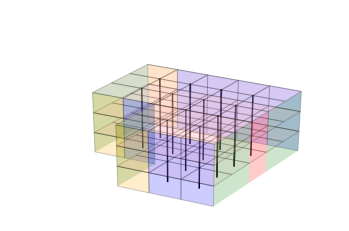

In [ ]:
# render arch model
arch_render(test_x[bldg])

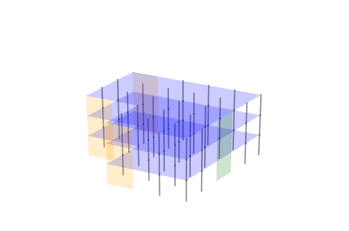

In [ ]:
# render structural model - label
struct_render(test_y[bldg])

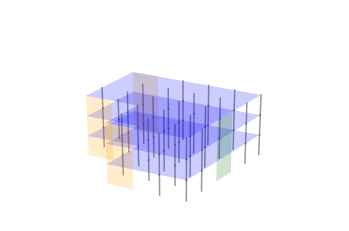

In [ ]:
struct_render(result)